In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns; sns.set_style("white")
import scipy
import scipy.stats as ss
import sklearn.metrics as metrics
import os
from tqdm import tqdm
from src.grn import grn

from matplotlib import font_manager as fm
fm.fontManager.addfont('Arial.ttf')
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]

%matplotlib inline

# Data

## Networks

In [2]:
home = '../../../../projects/genetwork/grn-paper/'
networks = pd.read_csv(home+'networks.tsv', sep='\t', index_col=0)
networks[['r','k','w','delta_in','delta_out']]=networks[['r','k','w','delta_in','delta_out']].astype(int)

# in this matrix, rows are KOs and columns are genes: (i,j) is the effect KO i has on gene j
ko = np.load(home + 'ko.npy', mmap_mode='r')
rna = np.load(home + 'rna.npy', mmap_mode='r')
edge = np.load(home + 'beta.npy', mmap_mode='r')
group = np.load(home + 'module.npy', mmap_mode='r')
degrade = np.load(home + 'degrade.npy', mmap_mode='r')

# see fig. 5 notebook
ixs = [678, 707, 647, 677]
rows = networks.loc[ixs,:]

rows

files     n   k  r  delta_in  \
678  /oak/stanford/groups/pritch/users/magu/project...  2000  10  4       100   
707  /oak/stanford/groups/pritch/users/magu/project...  2000  10  4       300   
647  /oak/stanford/groups/pritch/users/magu/project...  2000  10  4        30   
677  /oak/stanford/groups/pritch/users/magu/project...  2000  10  4       100   

     delta_out    w  
678          3  900  
707          3  400  
647          3  400  
677          3  400

## Co-expression

In [3]:
grns = {ix: nx.read_gpickle(home + 'grns/graph.{}.gpickle'.format(ix)) for ix in rows.index}

cells = {ix: grns[ix].set_rna_observation_model(lambda x: x[0, np.arange(0, x.shape[1], 1), :]
                    ).simulate_rna(x0 = rna[ix - 1, :],
                                   tmax = 12002,
                                   step = 30000,
                                   burnin = 2000,
                                   save = False)
         for ix in tqdm(rows.index)}

corrs = {ix: np.corrcoef(cells[ix].T) for ix in cells}

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:02<00:00, 45.52s/it]


# Fig. 6

files        /oak/stanford/groups/pritch/users/magu/project...
n                                                         2000
k                                                           10
r                                                            4
delta_in                                                   100
delta_out                                                    3
w                                                          900
Name: 678, dtype: object


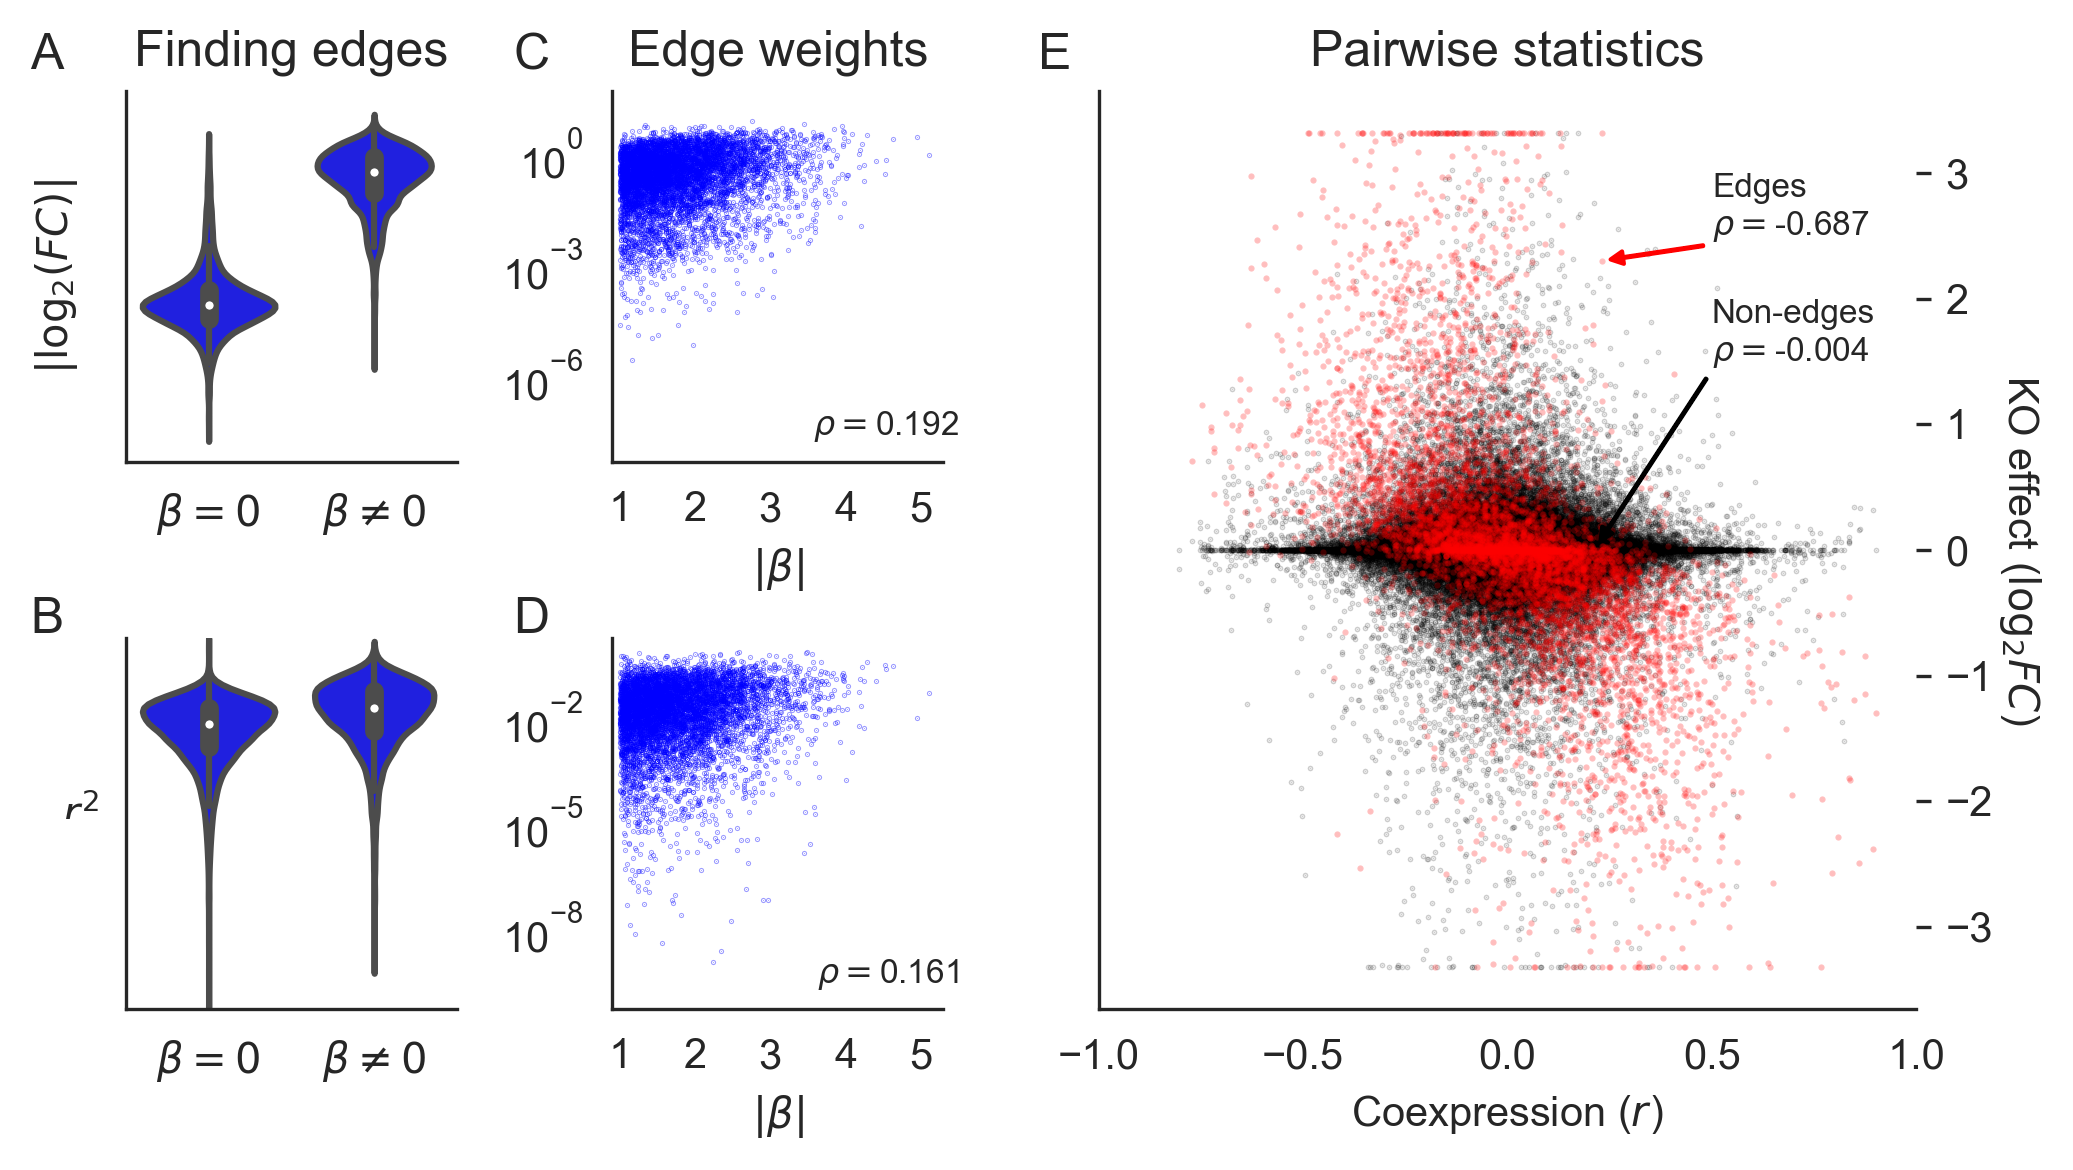

In [4]:
## set up the figure
fig = plt.figure(figsize=(7,4), dpi=300)

grid = gs.GridSpec(2, 4, figure=fig)

## pull data from specific network
ix = ixs[0]
print(networks.loc[ix,:])

# coexpression, ko effects, edges
r1 = corrs[ix]
fc = ko[ix-1,:,:]
E  = np.abs(edge[ix-1,:,:])
I  = np.eye(E.shape[0], dtype=bool)


for i,(df,label,c,yl) in enumerate(zip([np.abs(fc),r1**2], [r'$|\log_2(FC)_{}|$',r'$r^2_{}\quad$'], 'bb', [(5e-9, 5e1), (5e-11, 2)])):

    ## correlate edges with data
    ax = fig.add_subplot(grid[i,1:2])
    ax.plot(np.abs(E[E != 0]), df[E != 0], c+'.', ms=0.5, alpha=0.4)
    ax.set_xlabel(r'$|\beta_{}|$');
    ax.set_xlim(0.9, 5.3);
    ax.set_xticks([1,2,3,4,5])
    ax.semilogy();
    ax.set_ylim(*yl);
    ax.text(5.5, yl[0]*3, '{0}{1:.3f}'.format(r'$\rho=$', ss.spearmanr(np.abs(E[E!=0]), df[E!=0])[0]), 
            fontsize=8, horizontalalignment='right', verticalalignment='bottom');
    
    ## distributions of data for edges and non-edges
    ax1 = fig.add_subplot(grid[i,:1])
    sns.violinplot(data=pd.DataFrame({r'$\beta_{}=0$':np.log10(np.random.choice(df[E==0], size=10000)), 
                                      r'$\beta_{}\neq0$':np.log10(np.random.choice(df[E!=0], size=10000))
                                      }), 
                   color=c, 
                   ax=ax1)
    ax1.set_yticks(np.log10(ax.get_yticks())); ax1.set_yticklabels([]);
    ax1.set_ylabel(label, rotation=90*(i%2==0));
    ax1.set_ylim(np.log10(ax.get_ylim()));

    if i==0:
        ax1.set_title('Finding edges');
        ax.set_title('Edge weights');


## Correlate coexpression and KO effects
ax = fig.add_subplot(grid[:,-2:]);

maxfc = np.log2(10)

ax.plot(r1[(E == 0) & ~I], np.clip(fc[(E == 0) & ~I], -maxfc, maxfc), 'k.', ms=0.7, alpha=0.20)
ax.plot(r1[(E != 0) & ~I], np.clip(fc[(E != 0) & ~I], -maxfc, maxfc), 'r.', ms=1.0, alpha=0.25)

ax.set_xlabel('Coexpression ({})'.format(r'$r_{}$'));
ax.set_ylabel('KO effect ({})'.format(r'$\log_2 FC_{}$'), rotation=270, labelpad=12);
ax.set_xlim(-1., 1.);
ax.set_ylim(-1.1*maxfc, 1.1*maxfc);
ax.yaxis.tick_right();
ax.yaxis.set_label_position("right");

if maxfc > 99:
    ax.set_yscale('symlog');

ax.annotate('Non-edges\n{0}{1:.3f}'.format(r'$\rho=$', ss.spearmanr(r1.flatten(), fc.flatten())[0]),
            xy=(r1[np.where((0.05 < fc) & (fc < 1.5) & (r1 > 0.1) & (E==0) & ~I)][0]+0.02, 
                fc[np.where((0.05 < fc) & (fc < 1.5) & (r1 > 0.1) & (E==0) & ~I)][0]+0.01),
            xytext=(0.5, 2), 
            fontsize=8, ha='left', va='top', alpha=1.0,
            arrowprops=dict(facecolor='black', edgecolor='black', width=0.2, headlength=3, headwidth=3)
           );
ax.annotate('Edges\n{0}{1:.3f}'.format(r'$\rho=$', ss.spearmanr(r1[E!=0], fc[E!=0])[0]), 
            xy=(r1[np.where((2.5 > fc) & (fc > 2) & (r1 > 0.1) & (E!=0) & ~I)][0]+0.02, 
                fc[np.where((2.5 > fc) & (fc > 2) & (r1 > 0.1) & (E!=0) & ~I)][0]+0.01),
            xytext=(0.5, 3), 
            fontsize=8, ha='left', va='top', alpha=1.0,
            arrowprops=dict(facecolor='red', edgecolor='red', width=0.2, headlength=3, headwidth=3)
           );
            
ax.set_title('Pairwise statistics');



fig.tight_layout()

sns.despine()

if True:
    fig.text(0.02, 0.93, 'A', fontsize=12);
    fig.text(0.02, 0.46, 'B', fontsize=12);
    fig.text(0.25, 0.93, 'C', fontsize=12);
    fig.text(0.25, 0.46, 'D', fontsize=12);
    fig.text(0.5, 0.93, 'E', fontsize=12);
    plt.savefig('png/fig6.png');

# Supplement

## Synthetic GRN

files        /oak/stanford/groups/pritch/users/magu/project...
n                                                         2000
k                                                           10
r                                                            4
delta_in                                                   100
delta_out                                                    3
w                                                          900
Name: 678, dtype: object


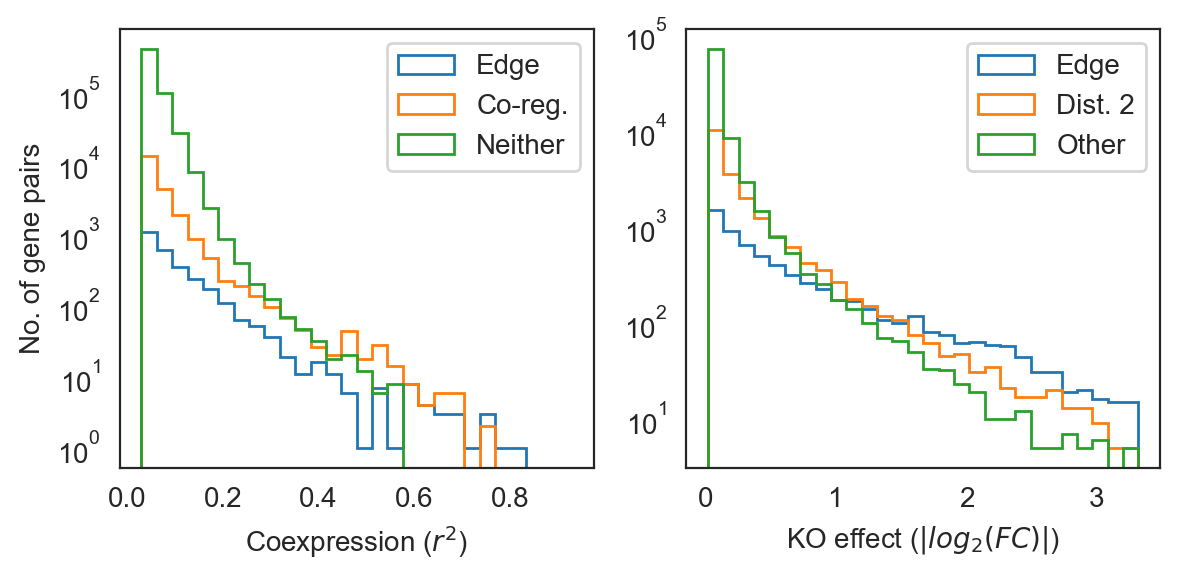

In [5]:
ix = ixs[0]
print(networks.loc[ix,:])

# coexpression, ko effects, edges
r1 = corrs[ix]
fc = ko[ix-1,:,:]
E  = np.abs(edge[ix-1,:,:])
I  = np.eye(E.shape[0], dtype=bool)


fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=200)

for c,label,pairs in zip(['b','r','g'], ['Edge','Co-reg.','Neither'], 
                         [(E!=0), (E==0) & (E.T==0) & (E.T @ E != 0) & ~np.eye(E.shape[0], dtype='bool'), (E==0) & (E.T==0) & (E.T @ E == 0) & ~np.eye(E.shape[0], dtype='bool')]):
    ax[0].hist((r1**2)[pairs & ~I], bins=np.linspace(0.03, 0.93, 29), histtype='step', label=label)

for c,label,pairs in zip(['b','r','g'], ['Edge','Dist. 2','Other'], [(E!=0), (E==0) & (E@E != 0), (E==0) & (E@E == 0)]):
    ax[1].hist(np.abs(fc)[pairs & ~I], bins=np.linspace(np.log2(1.01), np.log2(10), 29), histtype='step', label=label)
    
ax[0].set_xlabel('Coexpression ({})'.format(r'$r^2$'));
ax[0].set_ylabel('No. of gene pairs');
ax[0].legend();
ax[0].semilogy();

ax[1].semilogy();
ax[1].legend();
ax[1].set_xlabel('KO effect ({})'.format(r'$|log_2(FC)|$'));

plt.tight_layout();
plt.savefig('png/supplement/fig_s6a.png');

## Replogle

In [22]:
## Load perturbation effects
root = '/oak/stanford/groups/pritch/users/magu/data/GWPS-Replogle'
pvalues = pd.read_csv(os.path.join(root, 
                                   'supplement', 
                                   'anderson-darling p-values, BH-corrected.csv.gz'),
                      index_col=0)

remove = ['8769_ELOB_P1P2_ENSG00000103363','5047_MIA2_P1P2_ENSG00000150527','8535_BHLHE40_P1P2_ENSG00000134107']

## Also load bulk expression data 
import scanpy

norm_bulk = os.path.join(root, 'processed', 'K562_gwps_normalized_bulk_01.h5ad')
bulk = scanpy.read_h5ad(norm_bulk, backed='r').to_memory()

guides, genes = zip(*[(g,g.split('_')[-1]) for g in pvalues.columns if ~bulk.obs.loc[g,'core_control'] \
                                                                    and 'P1' in g.split('_')[2] \
                                                                    and g.split('_')[-1] in pvalues.index \
                                                                    and g not in remove
                     ])

# Pandas DataFrame, with symmetric rows and columns -- the diagonal has meaning!!
p = pvalues.loc[genes, guides]

# Compute baseline coexpression
f='figdata/figX.replogle.baseline_coexpr.pkl'
if not os.path.exists(f):
    # Load single-cell data
    norm_sc = os.path.join(root, 'processed', 'K562_gwps_normalized_singlecell_01.h5ad')
    sc = scanpy.read_h5ad(norm_sc, backed='r')

    # do it
    gene_ix = sc.var.index.isin(genes)
    X = sc.chunk_X(np.where(sc.obs.gene_id=='non-targeting')[0])[:,gene_ix]
    r = pd.DataFrame(X).corr()
    r.to_pickle(f)
else:
    r=pd.read_pickle(f)

r.shape, p.shape

((5247, 5247), (5247, 5247))

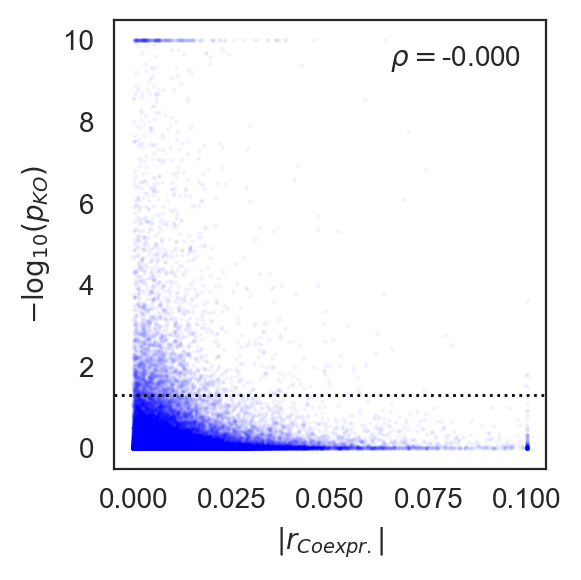

In [23]:
plt.figure(figsize=(3,3), dpi=200)

ix=np.random.choice(np.arange(5247*5247), 100000)

# exclude the diagonal
rx = r * (np.diag(np.diag(np.nan*np.eye(r.shape[0])))+1)
px = p * (np.diag(np.diag(np.nan*np.eye(r.shape[0])))+1)

# do variable transformations for plotting
lp_ix=-np.log10(px).values.flatten()[ix]
r2_ix=np.abs(rx).values.flatten()[ix]
is_ok=np.isfinite(lp_ix) & np.isfinite(r2_ix)
lp_ix=lp_ix[is_ok]
r2_ix=r2_ix[is_ok]

# plot
plt.plot(r2_ix.clip(max=0.1), lp_ix.clip(max=10), 'b.', alpha=0.05, ms=1)

# set the rest of the plot
#  rank correlation is on the filtered and transformed but unclipped values
plt.ylabel(r'$-\log_{10}(p_{KO})$');
plt.xlabel(r'$|r_{Coexpr.}|$');
plt.text(9.9e-2, 9.9e0, r'$\rho=$'+'{:.3f} '.format(ss.spearmanr(lp_ix, r2_ix)[0]),
         horizontalalignment='right',
         verticalalignment='top');
plt.axhline(-np.log10(0.05), color='k', linewidth=1, linestyle='dotted');

plt.tight_layout();
plt.savefig('png/supplement/fig_s6b.png');

# Bonus

Stuff that went into the above, but for all the specified networks

## Distributions (non-edges and edges)

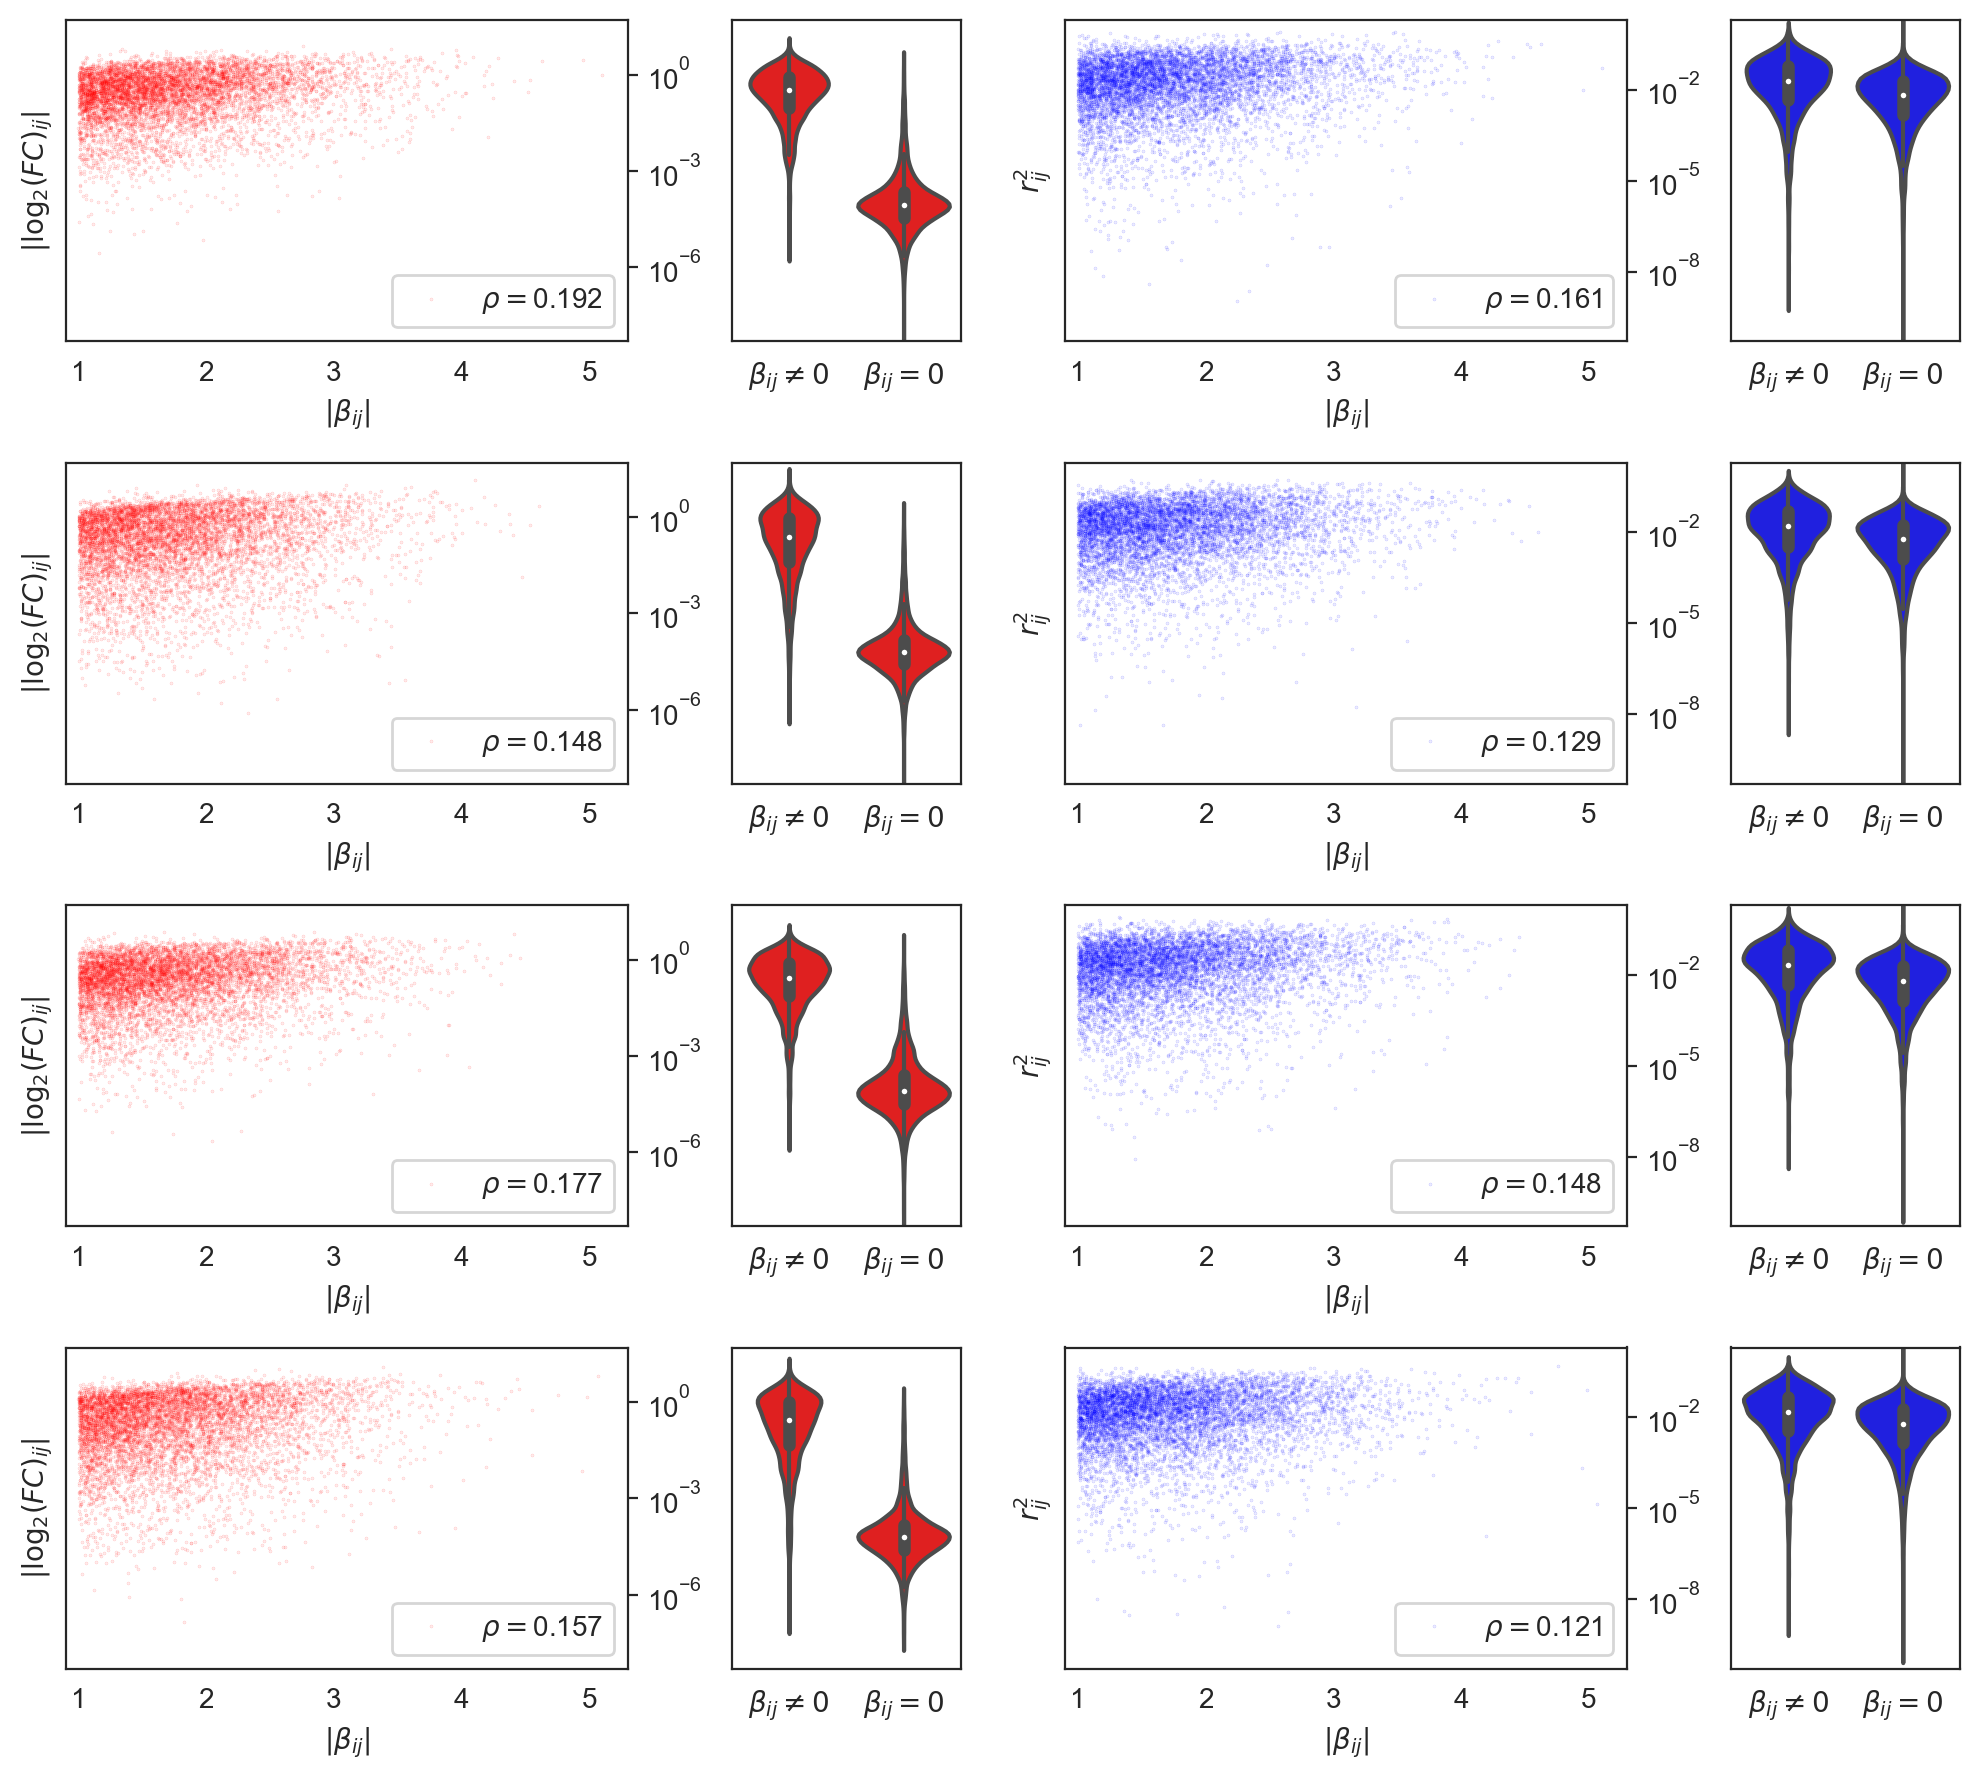

In [6]:
fig = plt.figure(figsize=(10, 9), dpi=200)

grid = gs.GridSpec(len(ixs), 6, figure=fig)

for i,(ix) in enumerate(ixs):#, pd.concat(rows,None))):
    r2 = corrs[ix]**2
    fc = np.abs(ko[ix-1,:,:])
    E  = np.abs(edge[ix-1,:,:])

    # correlate edges and ko fold-changes
    ax = fig.add_subplot(grid[i,:2])
    ax.plot(E[E != 0], fc[E != 0], 'r.', ms=0.5, alpha=0.2)
    ax.set_xlabel(r'$|\beta_{ij}|$');
    ax.set_xlim(0.9, 5.3);
    ax.set_ylabel(r'$|\log_2(FC)_{ij}|$');
    ax.semilogy();
    ax.set_ylim(5e-9, 5e1);
    ax.yaxis.tick_right();
    ax.legend(['{0}{1:.3f}'.format(r'$\rho=$', ss.spearmanr(E[E!=0], fc[E!=0])[0])], loc='lower right');

    # ko fold-changes for edges and non-edges
    ax1 = fig.add_subplot(grid[i,2:3])
    sns.violinplot(data=pd.DataFrame({r'$\beta_{ij}\neq0$':np.log10(np.random.choice(fc[E!=0], size=10000)), 
                                      r'$\beta_{ij}=0$':np.log10(np.random.choice(fc[E==0], size=10000))
                                     }), 
                   color='r', 
                   ax=ax1)
    ax1.set_yticks(np.log10(ax.get_yticks())); 
    ax1.set_yticklabels([]);
    ax1.set_ylim(np.log10(ax.get_ylim()));

    # correlate edges and baselline co-expression
    ax = fig.add_subplot(grid[i,3:5])
    ax.plot(E[E != 0], r2[E != 0], 'b.', ms=0.5, alpha=0.2)
    ax.set_xlabel(r'$|\beta_{ij}|$');
    ax.set_xlim(0.9, 5.3);
    ax.set_ylabel(r'$r^2_{ij}$');
    ax.yaxis.tick_right();
    ax.set_ylim(5e-11, 2);
    ax.legend(['{0}{1:.3f}'.format(r'$\rho=$', ss.spearmanr(E[E!=0], r2[E!=0])[0])], loc='lower right');
    ax.semilogy();

    # co-expression for edges and non-edges
    ax1 = fig.add_subplot(grid[i,5:6])
    sns.violinplot(data=pd.DataFrame({r'$\beta_{ij}\neq0$':np.log10(np.random.choice(r2[E!=0], size=10000)),
                                      r'$\beta_{ij}=0$':np.log10(np.random.choice(r2[E==0], size=10000))
                                     }),
                   color='b', 
                   ax=ax1);
    ax1.set_yticks(np.log10(ax.get_yticks())); 
    ax1.set_yticklabels([]);
    ax1.set_ylim(np.log10(ax.get_ylim()));
    #ax1.legend([r'$p=$'+'{:.1e}'.format(ss.ttest_ind(np.log10(np.random.choice(r2[E!=0], size=10000)), 
    #                                                 np.log10(np.random.choice(r2[E==0], size=10000)))[1])],
    #           loc='lower left')

    # correlation between r2 and KO
    #ax = fig.add_subplot(grid[i,6:8]);
    #ds = np.random.choice(np.arange(E.shape[0]**2 - E.shape[0]), size=(25000,), replace=False);
    #ax.plot(fc[~np.eye(E.shape[0], dtype=bool)][ds], r2[~np.eye(E.shape[0], dtype=bool)][ds], 'k.', ms=0.5, alpha=0.05);
    #ax.plot(fc[E != 0], r2[E != 0], 'r.', ms=0.8, alpha=0.1);
    #ax.legend(['Random pairs','Edges']);
    #ax.set_xlabel(r'$|\log_2(FC)_{ij}|$'); ax.set_ylabel(r'$r^2_{ij}$');

plt.tight_layout();

## Correlations (non-edges and edges)

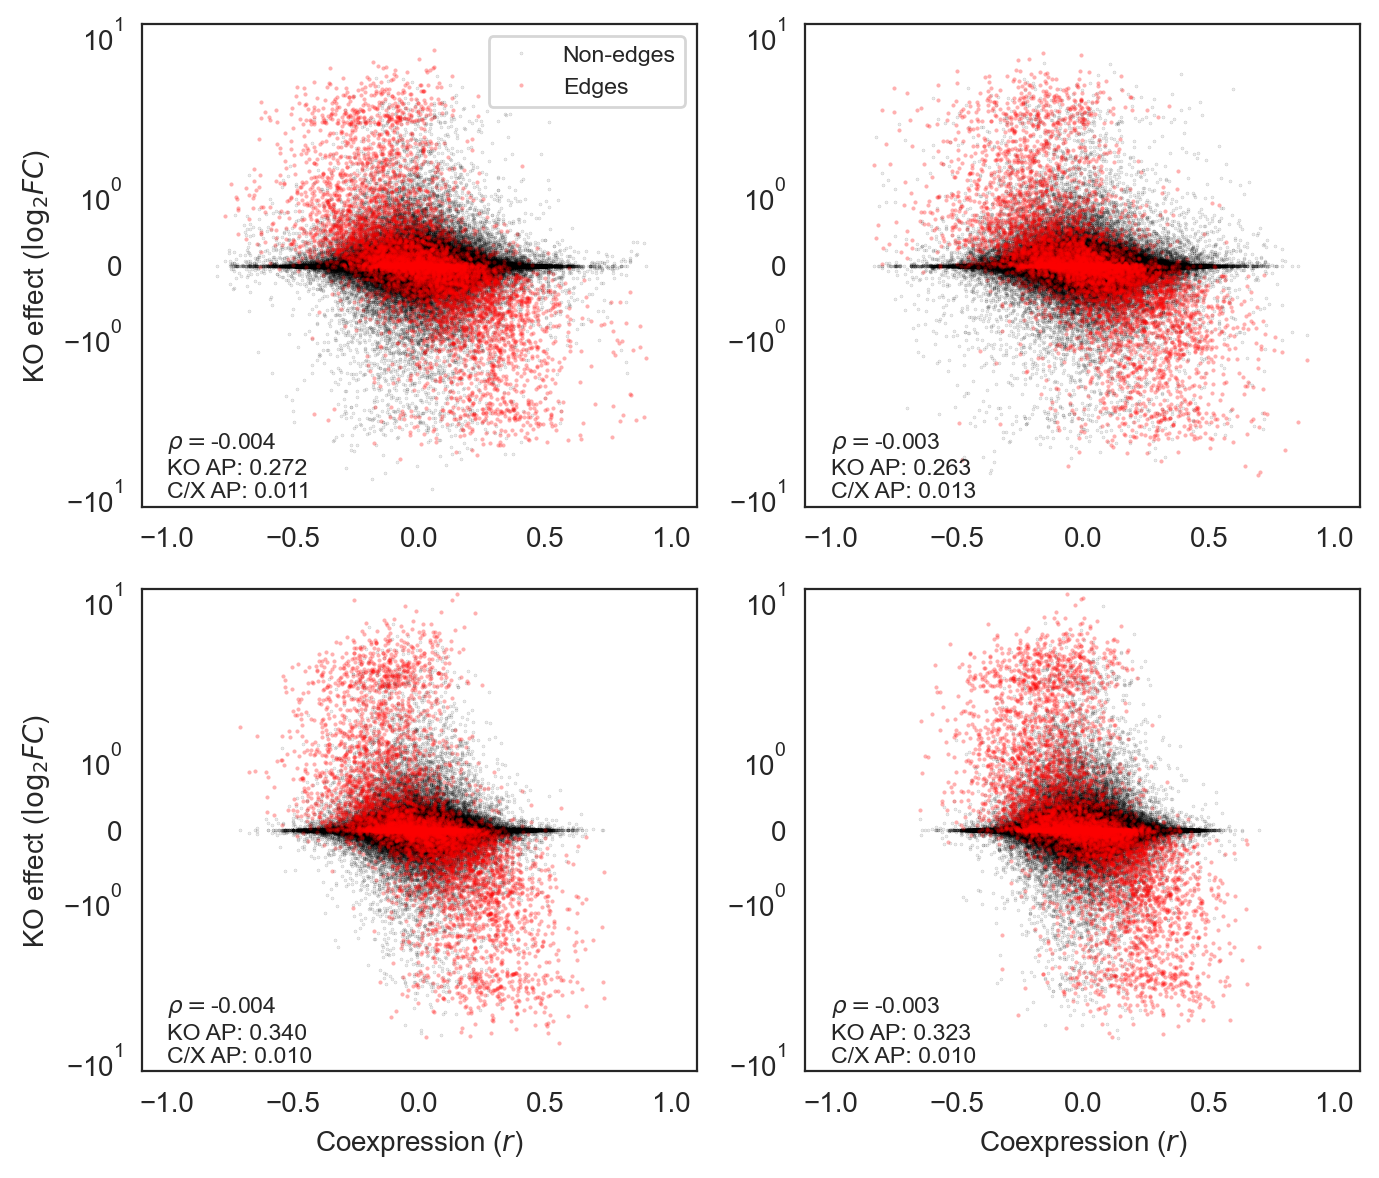

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(7,6), dpi=200)


for it,(ix,row) in enumerate(zip(ixs, rows)):
    i,j = (it % ax.shape[0]), (it // ax.shape[0])

    r = corrs[ix]
    maxfc = 11
    ix = ix-1 # ughhhh
    
    ax[i,j].plot(r[(edge[ix,:,:] == 0) & ~I], np.clip(ko[ix,:,:][(edge[ix,:,:] == 0) & ~I], -maxfc, maxfc), 'k.', ms=0.5, alpha=0.2)
    ax[i,j].plot(r[(edge[ix,:,:] != 0) & ~I], np.clip(ko[ix,:,:][(edge[ix,:,:] != 0) & ~I], -maxfc, maxfc), 'r.', ms=1, alpha=0.3)

    ax[i,j].set_xlabel('Coexpression ({})'.format(r'$r$') if i==ax.shape[0]-1 else ''); 
    ax[i,j].set_ylabel('KO effect ({})'.format(r'$\log_2 FC$') if j==0 else '');
    ax[i,j].set_xlim(-1.1, 1.1);
    ax[i,j].set_ylim(-1.1*maxfc, 1.1*maxfc);
    if maxfc > 2:
        ax[i,j].set_yscale('symlog');
    ax[i,j].text(-1, -maxfc, 
                 '{0}{1:.3f}\nKO AP: {2:.3f}\nC/X AP: {3:.3f}'.format(
                     r'$\rho=$', 
                     ss.spearmanr(r.flatten(), ko[ix,:,:].flatten())[0],
                     metrics.average_precision_score((edge[ix,:,:] != 0).flatten(), np.abs(ko[ix,:,:]).flatten()),
                     metrics.average_precision_score((edge[ix,:,:] != 0).flatten(), np.abs(r).flatten())                     
                 ),
                 verticalalignment='bottom',
                fontsize='small');

ax[0,0].legend(['Non-edges', 'Edges'], fontsize='small', loc='upper right');
plt.tight_layout();

## Prediction (coexpression and KO effects)

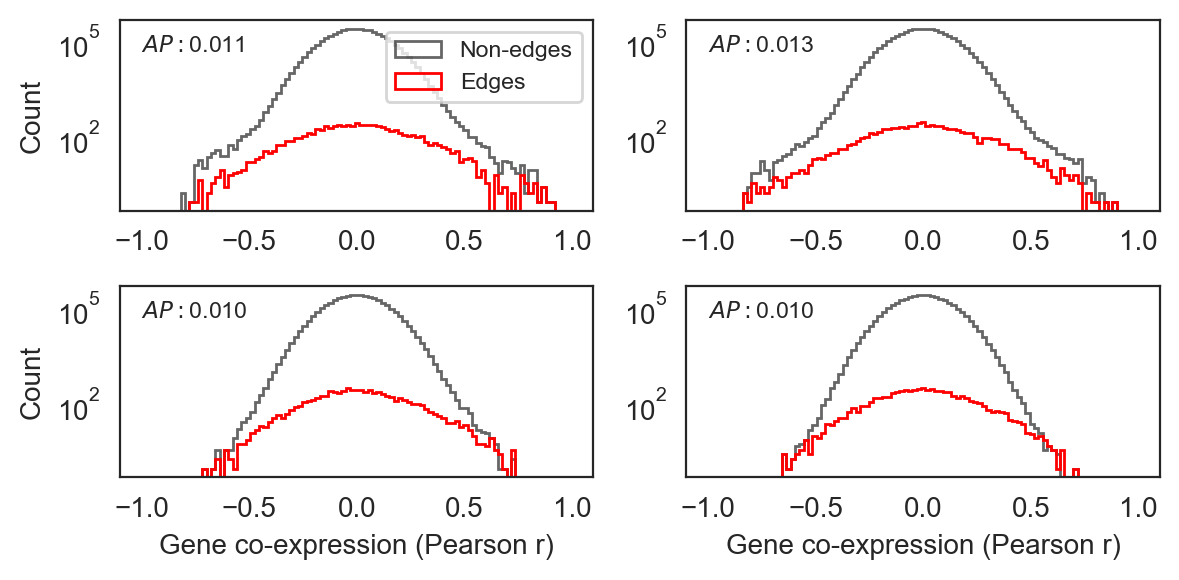

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(6,3), dpi=200)

density = 0

for it,(ix,row) in enumerate(zip(ixs, rows)):
    i,j = (it % ax.shape[0]), (it // ax.shape[0])

    r = corrs[ix]
    ix = ix-1

    ax[i,j].hist(r[(edge[ix,:,:] == 0) & ~I], 
                 bins=np.linspace(-1, 1, 100), 
                 color='k',
                 alpha=0.6,
                 histtype='step',
                 density=density
                 )

    ax[i,j].hist(r[(edge[ix,:,:] != 0) & ~I], 
                 bins=np.linspace(-1, 1, 100), 
                 color='r',
                 alpha=1.0,
                 histtype='step',
                 density=density
                 )

    ax[i,j].set_xlabel('Gene co-expression (Pearson r)' if i==ax.shape[0]-1 else '');
    ax[i,j].set_ylabel(['Count','Density'][density] if j==0 else ''); 
    if not density:
        ax[i,j].semilogy();

    ax[i,j].text(-1, 0.1*ax[i,j].get_ylim()[1], 
                 '{0}{1:.3f}'.format(r'$AP:$', 
                                     metrics.average_precision_score((edge[ix,:,:] != 0).flatten(), np.abs(r).flatten())
                                    ),
                 fontsize='small'
                );

    
ax[0,0].legend(['Non-edges', 'Edges'], fontsize='small');
plt.tight_layout();

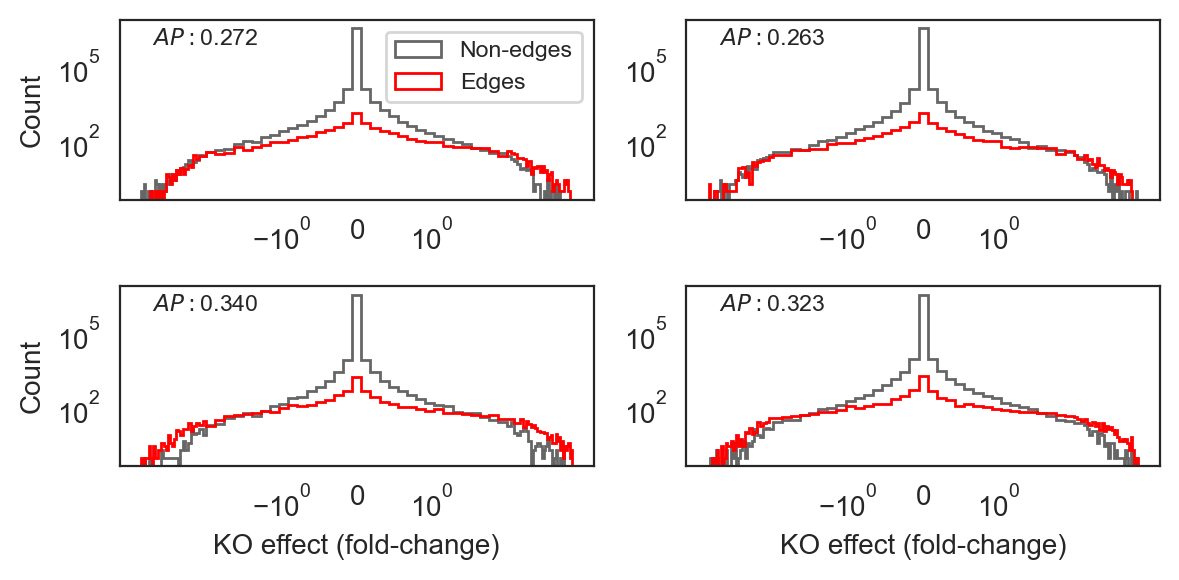

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(6,3), dpi=200)

density=0

for it,(ix,row) in enumerate(zip(ixs, rows)):
    i,j = (it % ax.shape[0]), (it // ax.shape[0])
    ix = ix-1

    ax[i,j].hist(ko[ix,:,:][(edge[ix,:,:] == 0) & ~I], 
                 bins=np.linspace(-6, 6, 100), 
                 color='k',
                 alpha=0.6,
                 histtype='step',
                 density=density
                 )

    ax[i,j].hist(ko[ix,:,:][(edge[ix,:,:] != 0) & ~I], 
                 bins=np.linspace(-6, 6, 100), 
                 color='r',
                 alpha=1.0,
                 histtype='step',
                 density=density
                 )

    ax[i,j].set_xscale('symlog');
    #ax[i,j].set_xticks([-5, -1, -0.2, 0, 0.2, 1, 5]);
    ax[i,j].set_xlabel('KO effect (fold-change)' if i==ax.shape[0]-1 else '');
    ax[i,j].set_ylabel(['Count','Density'][density] if j==0 else ''); 
    if not density:
        ax[i,j].semilogy();

    ax[i,j].text(-5, 0.1*ax[i,j].get_ylim()[1], 
                 '{0}{1:.3f}'.format(r'$AP:$', 
                                     metrics.average_precision_score((edge[ix,:,:] != 0).flatten(), 
                                                                     np.abs(ko[ix,:,:]).flatten())),
                 fontsize='small'
                );

    
ax[0,0].legend(['Non-edges', 'Edges'], fontsize='small');
plt.tight_layout();

files        /oak/stanford/groups/pritch/users/magu/project...
n                                                         2000
k                                                           50
r                                                            4
delta_in                                                   100
delta_out                                                    3
w                                                            1
Name: 679, dtype: object


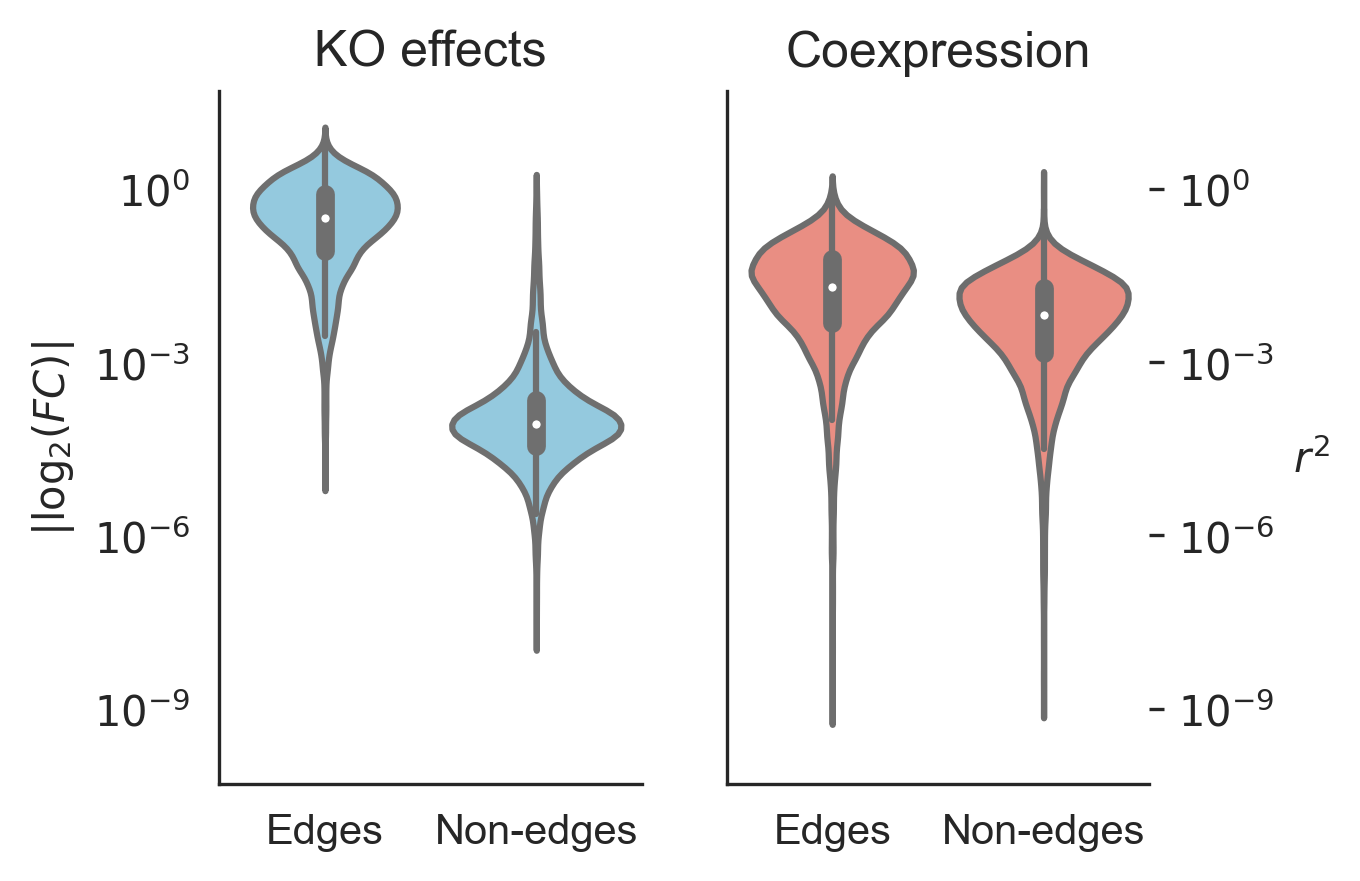

In [10]:
#fig = plt.figure(figsize=(9,4), dpi=300)
#grid = gs.GridSpec(2, 5, figure=fig)
fig,ax = plt.subplots(1,2,figsize=(4,3),dpi=300)

## pull data from specific network
ix = ixs[0]
print(networks.iloc[ix,:])

r1 = corrs[ix]
ix = ix-1
fc = ko[ix,:,:]
E  = np.abs(edge[ix,:,:])

sns.set_style('white');
sns.violinplot(data=pd.DataFrame({'Edges':np.log10(np.random.choice(np.abs(fc)[E!=0], size=10000)), 
                                  'Non-edges':np.log10(np.random.choice(np.abs(fc)[(E==0) & (E.T==0)], size=10000))
                                 }), 
               color='skyblue',
               ax=ax[0])
ax[0].set_ylabel(r'$|\log_2(FC)_{}|$');
ax[0].set_ylim(np.log10([5e-11,5e1]));
ax[0].set_yticks([-9,-6,-3,0]);
ax[0].set_yticklabels([r'$'+'10^{'+str(int(t))+'}'+'$' if int(t)%3==0 else '' for t in ax[0].get_yticks()])
ax[0].set_title('KO effects');

sns.violinplot(data=pd.DataFrame({'Edges':np.log10(np.random.choice((r1**2)[E!=0], size=10000)), 
                                  'Non-edges':np.log10(np.random.choice((r1**2)[E==0], size=10000))
                                 }), 
               color='salmon', log_scale=False,
               ax=ax[1])
ax[1].set_ylabel(r'$\quad r^2$'+'\n ', rotation=0);
ax[1].set_ylim(np.log10([5e-11,5e1]));
ax[1].set_yticks(ax[0].get_yticks());
ax[1].set_yticklabels(ax[0].get_yticklabels());
ax[1].yaxis.tick_right(); 
ax[1].yaxis.set_label_position('right');
ax[1].set_title('Coexpression');
sns.despine();

#fig.tight_layout()

In [11]:
(E!=0).mean(), ((E==0) & (E.T==0) & (E.T @ E != 0) & ~np.eye(E.shape[0], dtype='bool')).mean(), ((E==0) & (E.T==0) & (E.T @ E == 0)).mean()

(0.00173275, 0.0246, 0.97153175)

files        /oak/stanford/groups/pritch/users/magu/project...
n                                                         2000
k                                                           50
r                                                            4
delta_in                                                   100
delta_out                                                    3
w                                                            1
Name: 679, dtype: object
0.00173275 0.0246 0.97153175


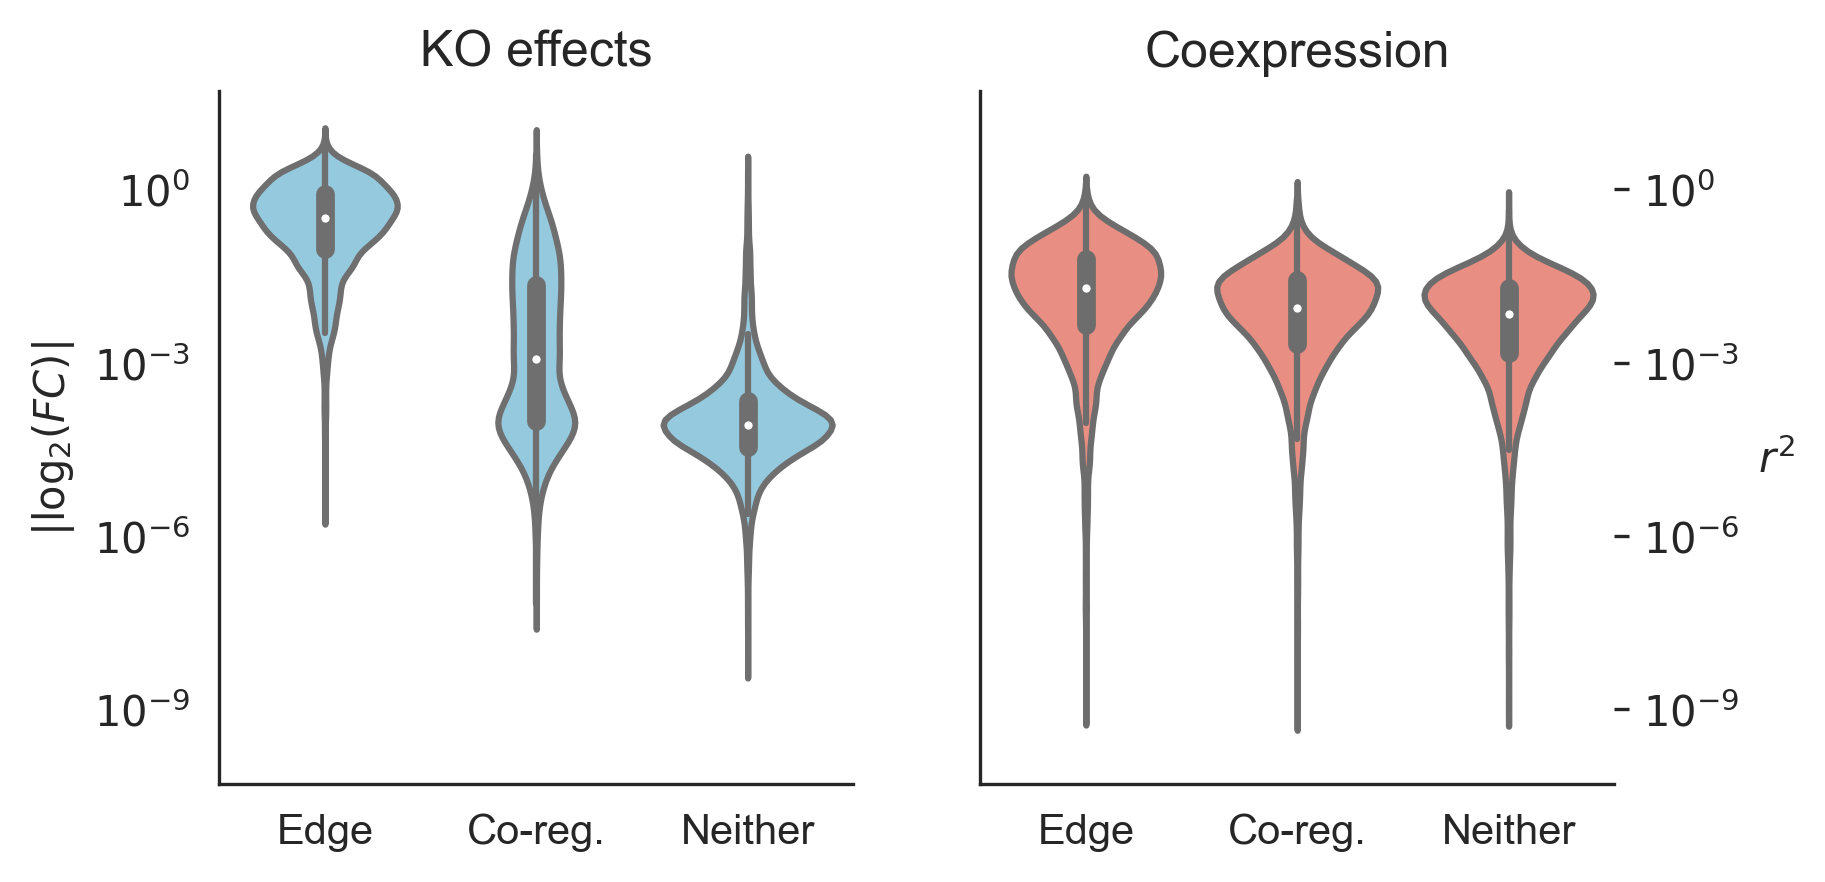

In [12]:
fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=300)

## pull data from specific network
ix = ixs[0]
print(networks.iloc[ix,:])
r1 = corrs[ix]
ix = ix-1

#r1 = np.corrcoef(rna[ix,0,-1000:,:].T)
print((E!=0).mean(), ((E==0) & (E.T==0) & (E.T @ E != 0) & ~np.eye(E.shape[0], dtype='bool')).mean(), ((E==0) & (E.T==0) & (E.T @ E == 0)).mean())

sns.set_style('white');
sns.violinplot(data=pd.DataFrame({'Edge':np.log10(np.random.choice(np.abs(fc)[E!=0], size=10000)), 
                                  'Co-reg.':np.log10(np.random.choice(np.abs(fc)[(E==0) & (E.T==0) & (E.T @ E != 0) & ~np.eye(E.shape[0], dtype='bool')], size=10000)),
                                  'Neither':np.log10(np.random.choice(np.abs(fc)[(E==0) & (E.T==0) & (E.T @ E == 0)], size=10000))
                                 }),
               color='skyblue',
               ax=ax[0])
ax[0].set_ylabel(r'$|\log_2(FC)_{}|$');
ax[0].set_ylim(np.log10([5e-11,5e1]));
ax[0].set_yticks([-9,-6,-3,0]);
ax[0].set_yticklabels([r'$'+'10^{'+str(int(t))+'}'+'$' if int(t)%3==0 else '' for t in ax[0].get_yticks()])
ax[0].set_title('KO effects');

sns.violinplot(data=pd.DataFrame({'Edge':np.log10(np.random.choice((r1**2)[E!=0], size=10000)), 
                                  'Co-reg.':np.log10(np.random.choice((r1**2)[(E==0) & (E.T==0) & (E.T @ E != 0) & ~np.eye(E.shape[0], dtype='bool')], size=10000)),
                                  'Neither':np.log10(np.random.choice((r1**2)[(E==0) & (E.T==0) & (E.T @ E == 0)], size=10000))
                                 }),#.melt(), x='value', y='variable', 
               color='salmon', log_scale=False,
               ax=ax[1])
ax[1].set_ylabel(r'$\quad r^2$'+'\n ', rotation=0);
ax[1].set_ylim(np.log10([5e-11,5e1]));
ax[1].set_yticks(ax[0].get_yticks());
ax[1].set_yticklabels(ax[0].get_yticklabels());
ax[1].yaxis.tick_right(); 
ax[1].yaxis.set_label_position('right');
ax[1].set_title('Coexpression');
sns.despine();

#fig.tight_layout()

<AxesSubplot:xlabel='value', ylabel='variable'>

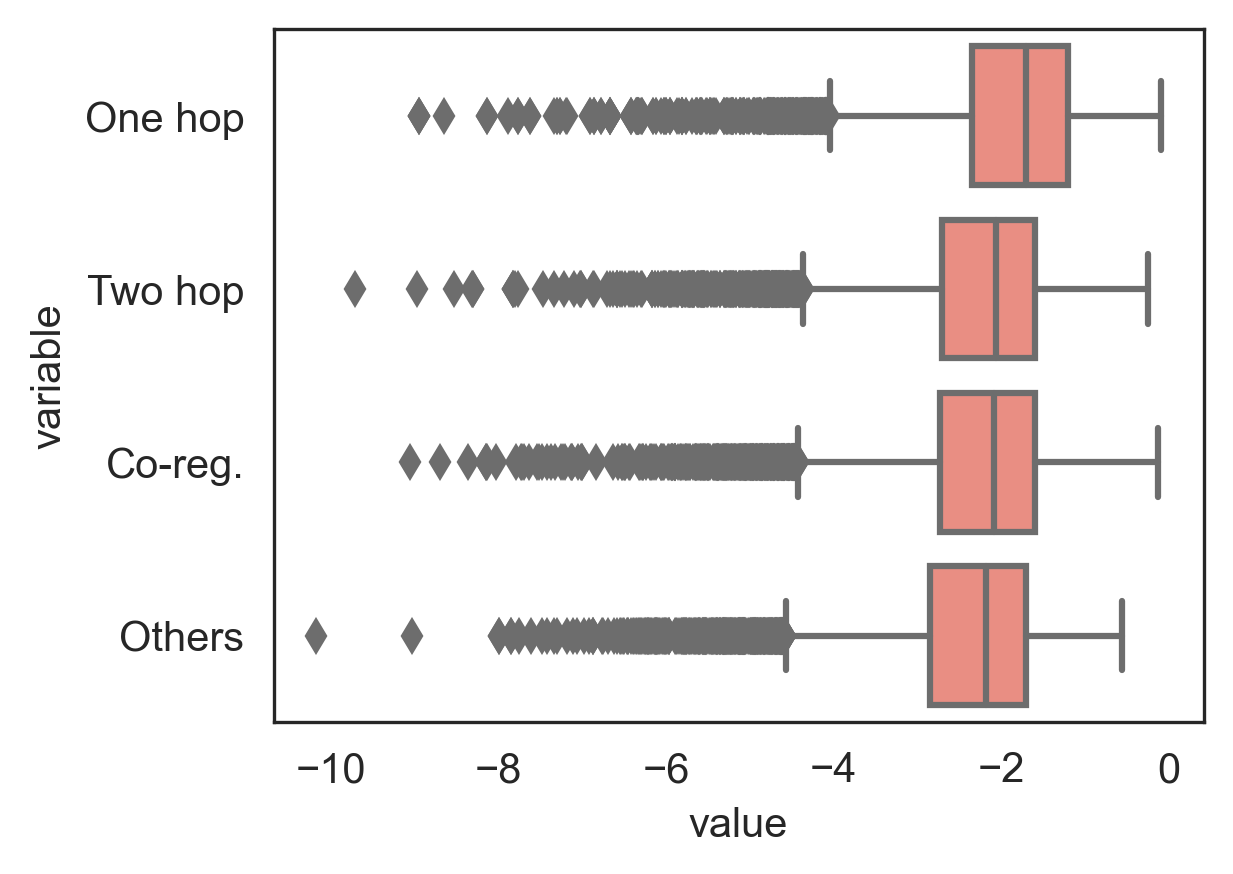

In [13]:
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4,3));

strat = pd.DataFrame({'One hop':np.log10(np.random.choice((r1**2)[E!=0], size=10000)), 
                      'Two hop':np.log10(np.random.choice((r1**2)[(E==0) & (E.T==0) & ((E@E != 0) | (E.T@E.T != 0)) & ~np.eye(E.shape[0], dtype='bool')], size=10000)), 
                      'Co-reg.':np.log10(np.random.choice((r1**2)[(E==0) & (E.T==0) & (E.T @ E != 0) & (E@E == 0) & (E.T@E.T == 0) & ~np.eye(E.shape[0], dtype='bool')], size=10000)),
                      'Others' :np.log10(np.random.choice((r1**2)[(E==0) & (E.T==0) & (E.T @ E == 0) & (E@E == 0) & (E.T@E.T == 0) & ~np.eye(E.shape[0], dtype='bool')], size=10000))
                     })

sns.boxplot(data=strat.melt(), x='value', y='variable', 
               color='salmon',
               ax=ax)

In [14]:
np.sum(E != 0), \
np.sum((E==0) & (E.T==0) & ((E@E != 0) | (E.T@E.T != 0)) & ~np.eye(E.shape[0], dtype='bool')), \
np.sum((E==0) & (E.T==0) & (E.T @ E != 0) & (E@E == 0) & (E.T@E.T == 0) & ~np.eye(E.shape[0], dtype='bool')), \
np.sum((E==0) & (E.T==0) & (E.T @ E == 0) & (E@E == 0) & (E.T@E.T == 0) & ~np.eye(E.shape[0], dtype='bool'))

(6931, 50126, 72996, 3861404)

In [16]:
for c in strat.columns:
    for d in strat.columns:
        print(c,d)
        print(ss.ttest_ind(strat[c], strat[d]))

One hop One hop
Ttest_indResult(statistic=0.0, pvalue=1.0)
One hop Two hop
Ttest_indResult(statistic=26.200270054270728, pvalue=8.510966120562996e-149)
One hop Co-reg.
Ttest_indResult(statistic=27.297871068127865, pvalue=4.005383581995044e-161)
One hop Others
Ttest_indResult(statistic=35.811392654180885, pvalue=2.7825372733839348e-272)
Two hop One hop
Ttest_indResult(statistic=-26.200270054270728, pvalue=8.510966120562996e-149)
Two hop Two hop
Ttest_indResult(statistic=0.0, pvalue=1.0)
Two hop Co-reg.
Ttest_indResult(statistic=1.3499639554492688, pvalue=0.1770428242041924)
Two hop Others
Ttest_indResult(statistic=9.661162164369548, pvalue=4.925316357121014e-22)
Co-reg. One hop
Ttest_indResult(statistic=-27.297871068127865, pvalue=4.005383581995044e-161)
Co-reg. Two hop
Ttest_indResult(statistic=-1.3499639554492688, pvalue=0.1770428242041924)
Co-reg. Co-reg.
Ttest_indResult(statistic=0.0, pvalue=1.0)
Co-reg. Others
Ttest_indResult(statistic=8.217411688375144, pvalue=2.204804885704349e-1

files        /oak/stanford/groups/pritch/users/magu/project...
n                                                         2000
k                                                           50
r                                                            4
delta_in                                                   100
delta_out                                                    3
w                                                            1
Name: 679, dtype: object
0.00173275 0.0246 0.97153175


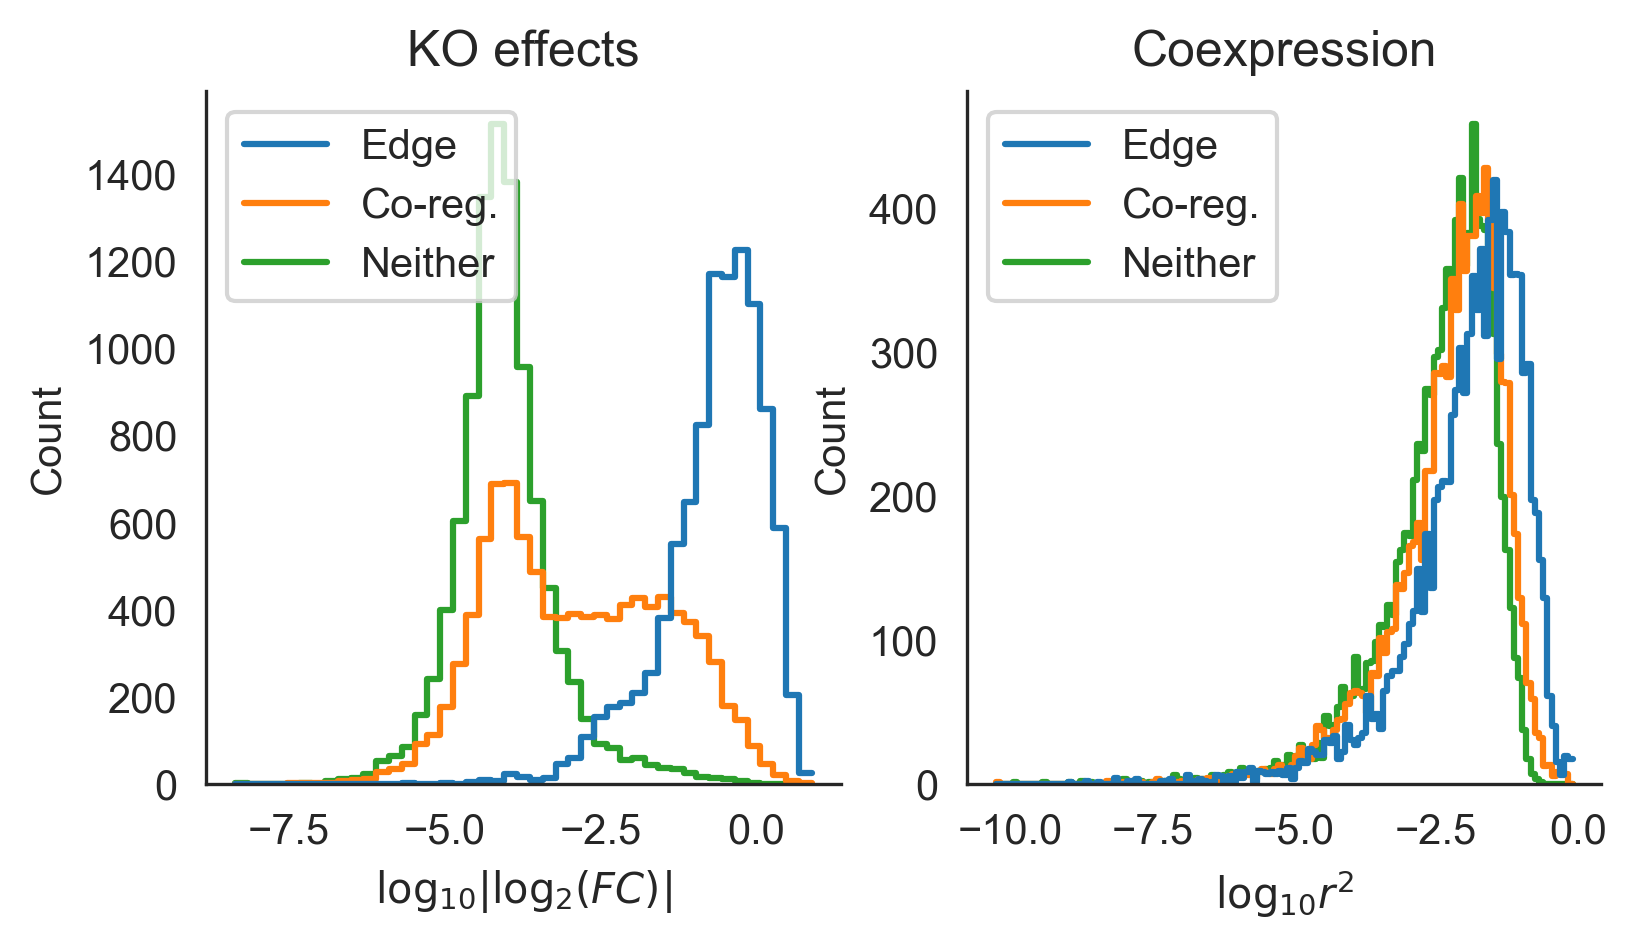

In [17]:
#fig = plt.figure(figsize=(9,4), dpi=300)
#grid = gs.GridSpec(2, 5, figure=fig)
fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=300)

## pull data from specific network
ix = ixs[0]
print(networks.iloc[ix,:])

r1 = corrs[ix]
ix = ix-1
print((E!=0).mean(), ((E==0) & (E.T==0) & (E.T @ E != 0) & ~np.eye(E.shape[0], dtype='bool')).mean(), ((E==0) & (E.T==0) & (E.T @ E == 0)).mean())

sns.set_style('white');
sns.histplot(data=pd.DataFrame({'Edge':np.log10(np.random.choice(np.abs(fc)[E!=0], size=10000)), 
                                  'Co-reg.':np.log10(np.random.choice(np.abs(fc)[(E==0) & (E.T==0) & (E.T @ E != 0) & ~np.eye(E.shape[0], dtype='bool')], size=10000)),
                                  'Neither':np.log10(np.random.choice(np.abs(fc)[(E==0) & (E.T==0) & (E.T @ E == 0)], size=10000))
                                 }),#.melt(), x='value', y='variable',
               color='skyblue', fill=False, element='step',
               ax=ax[0])
ax[0].set_xlabel(r'$\log_{10}|\log_2(FC)_{}|$');# + '  or   ' + r'$r^2_{ij}$');
ax[0].set_title('KO effects');

sns.histplot(data=pd.DataFrame({'Edge':np.log10(np.random.choice((r1**2)[E!=0], size=10000)), 
                                  'Co-reg.':np.log10(np.random.choice((r1**2)[(E==0) & (E.T==0) & (E.T @ E != 0) & ~np.eye(E.shape[0], dtype='bool')], size=10000)),
                                  'Neither':np.log10(np.random.choice((r1**2)[(E==0) & (E.T==0) & (E.T @ E == 0)], size=10000))
                                 }),#.melt(), x='value', y='variable', 
               color='salmon', fill=False, element='step',
               ax=ax[1])
ax[1].set_xlabel(r'$\log_{10}{r^2}$');
ax[1].set_title('Coexpression');
sns.despine();

#fig.tight_layout()

0.00173275 0.0246 0.97153175


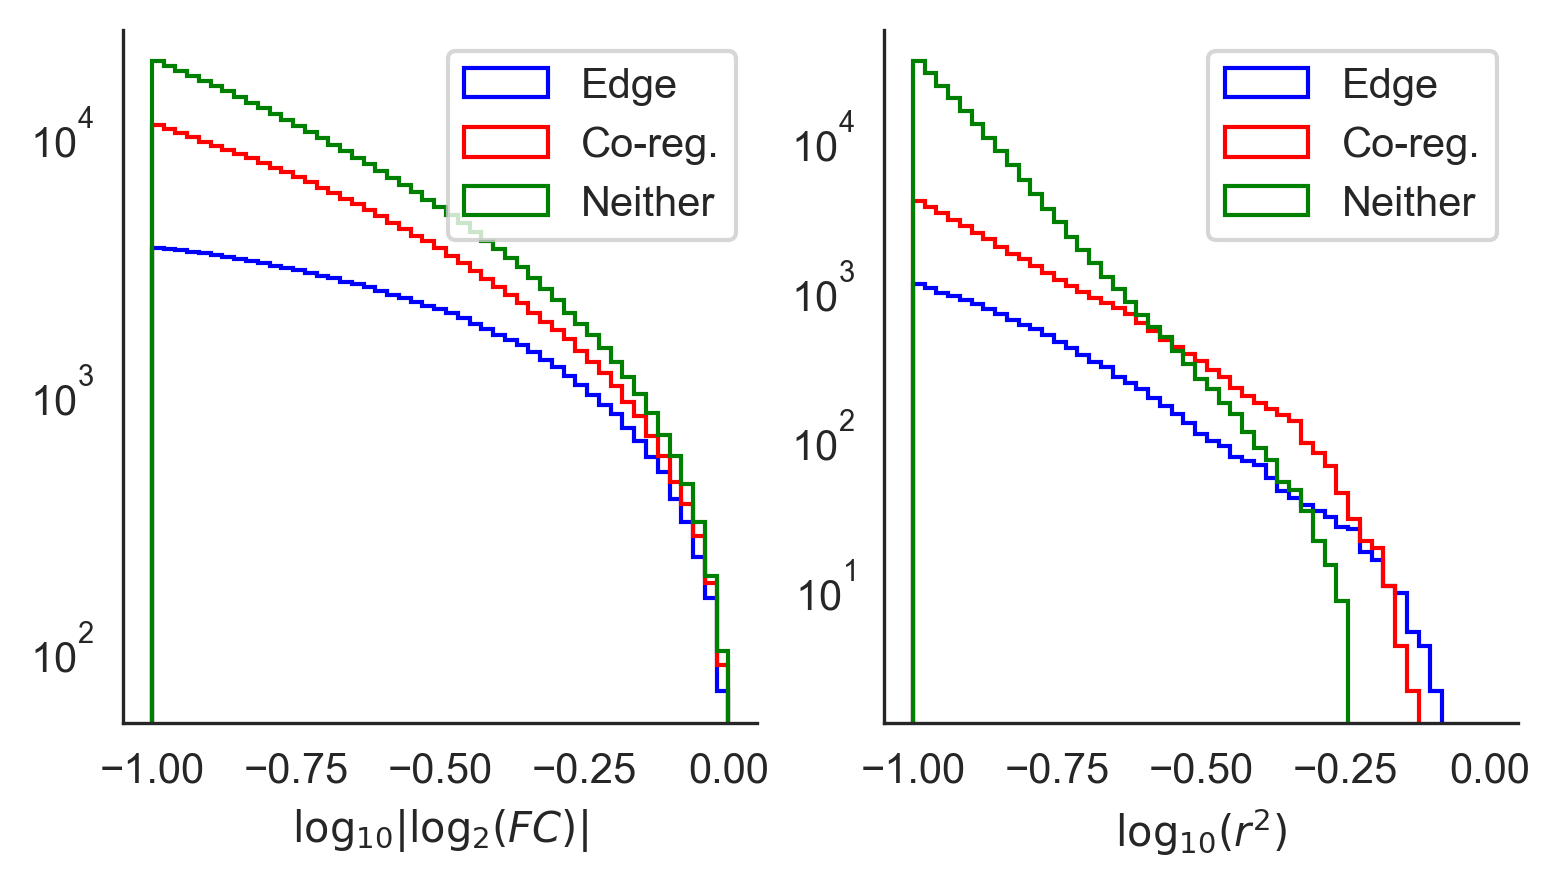

In [18]:
#fig = plt.figure(figsize=(9,4), dpi=300)
#grid = gs.GridSpec(2, 5, figure=fig)
fig,ax = plt.subplots(1,2,figsize=(6,3),dpi=300)

print((E!=0).mean(), ((E==0) & (E.T==0) & (E.T @ E != 0) & ~np.eye(E.shape[0], dtype='bool')).mean(), ((E==0) & (E.T==0) & (E.T @ E == 0)).mean())

sns.set_style('white');
for c,label,pairs in zip(['b','r','g'], ['Edge','Co-reg.','Neither'], 
                         [(E!=0), (E==0) & (E.T==0) & (E.T @ E != 0) & ~np.eye(E.shape[0], dtype='bool'), (E==0) & (E.T==0) & (E.T @ E == 0)]):
    for i,(df,stat) in enumerate(zip([np.log10(np.abs(fc)),np.log10(r1**2)],[r'$\log_{10}|\log_2(FC)|$', r'$\log_{10}(r^2)$'])):
        ax[i].hist(df[pairs & ~I], bins=np.linspace(-1,0,50), cumulative=-1, color=c, histtype='step', label=label)
        ax[i].set_xlabel(stat);
        ax[i].set_ylabel('');
        ax[i].semilogy();

ax[0].legend(); ax[1].legend();
sns.despine();

#fig.tight_layout()

## Extended network properties

In [19]:
stats = ['rho_r_ko', 'ap_ko', 'ap_r2']
fname = 'networks.v2.figs.csv'

if not os.path.exists(fname):
    temp = {s:[] for s in stats}
    for ix in tqdm(networks.index):
        corrs = np.corrcoef(nx.read_gpickle(home + 'grns/graph.{}.gpickle'.format(ix)
                                           ).set_rna_observation_model(lambda x: x[0, np.arange(0, x.shape[1], 1), :]
                                           ).simulate_rna(x0 = rna[ix - 1, :],
                                                          tmax = 1004,
                                                          step = 9999,
                                                          burnin = 2,
                                                          save = False).T)
        kos = ko[ix-1]
        edges = (edge[ix-1] != 0)

        temp['rho_r_ko'].append(ss.pearsonr(corrs.flatten(), kos.flatten())[0])
        temp['ap_ko'].append(metrics.average_precision_score(edges.flatten(), np.abs(kos).flatten()))
        temp['ap_r2'].append(metrics.average_precision_score(edges.flatten(), np.abs(corrs).flatten()))
    
    for s in stats:
        networks[s] = temp[s]
    networks.to_csv('networks.v2.figs.csv')
else:
    networks = pd.read_csv('networks.v2.figs.csv')

display(networks[['rho_r_ko','ap_ko','ap_r2']].describe())

rho_r_ko        ap_ko        ap_r2
count  1920.000000  1920.000000  1920.000000
mean     -0.006661     0.256407     0.002992
std       0.005662     0.166485     0.001864
min      -0.073018     0.007000     0.000767
25%      -0.008013     0.113450     0.001270
50%      -0.006730     0.222719     0.002316
75%      -0.004859     0.400181     0.004179
max       0.027796     0.711137     0.009148

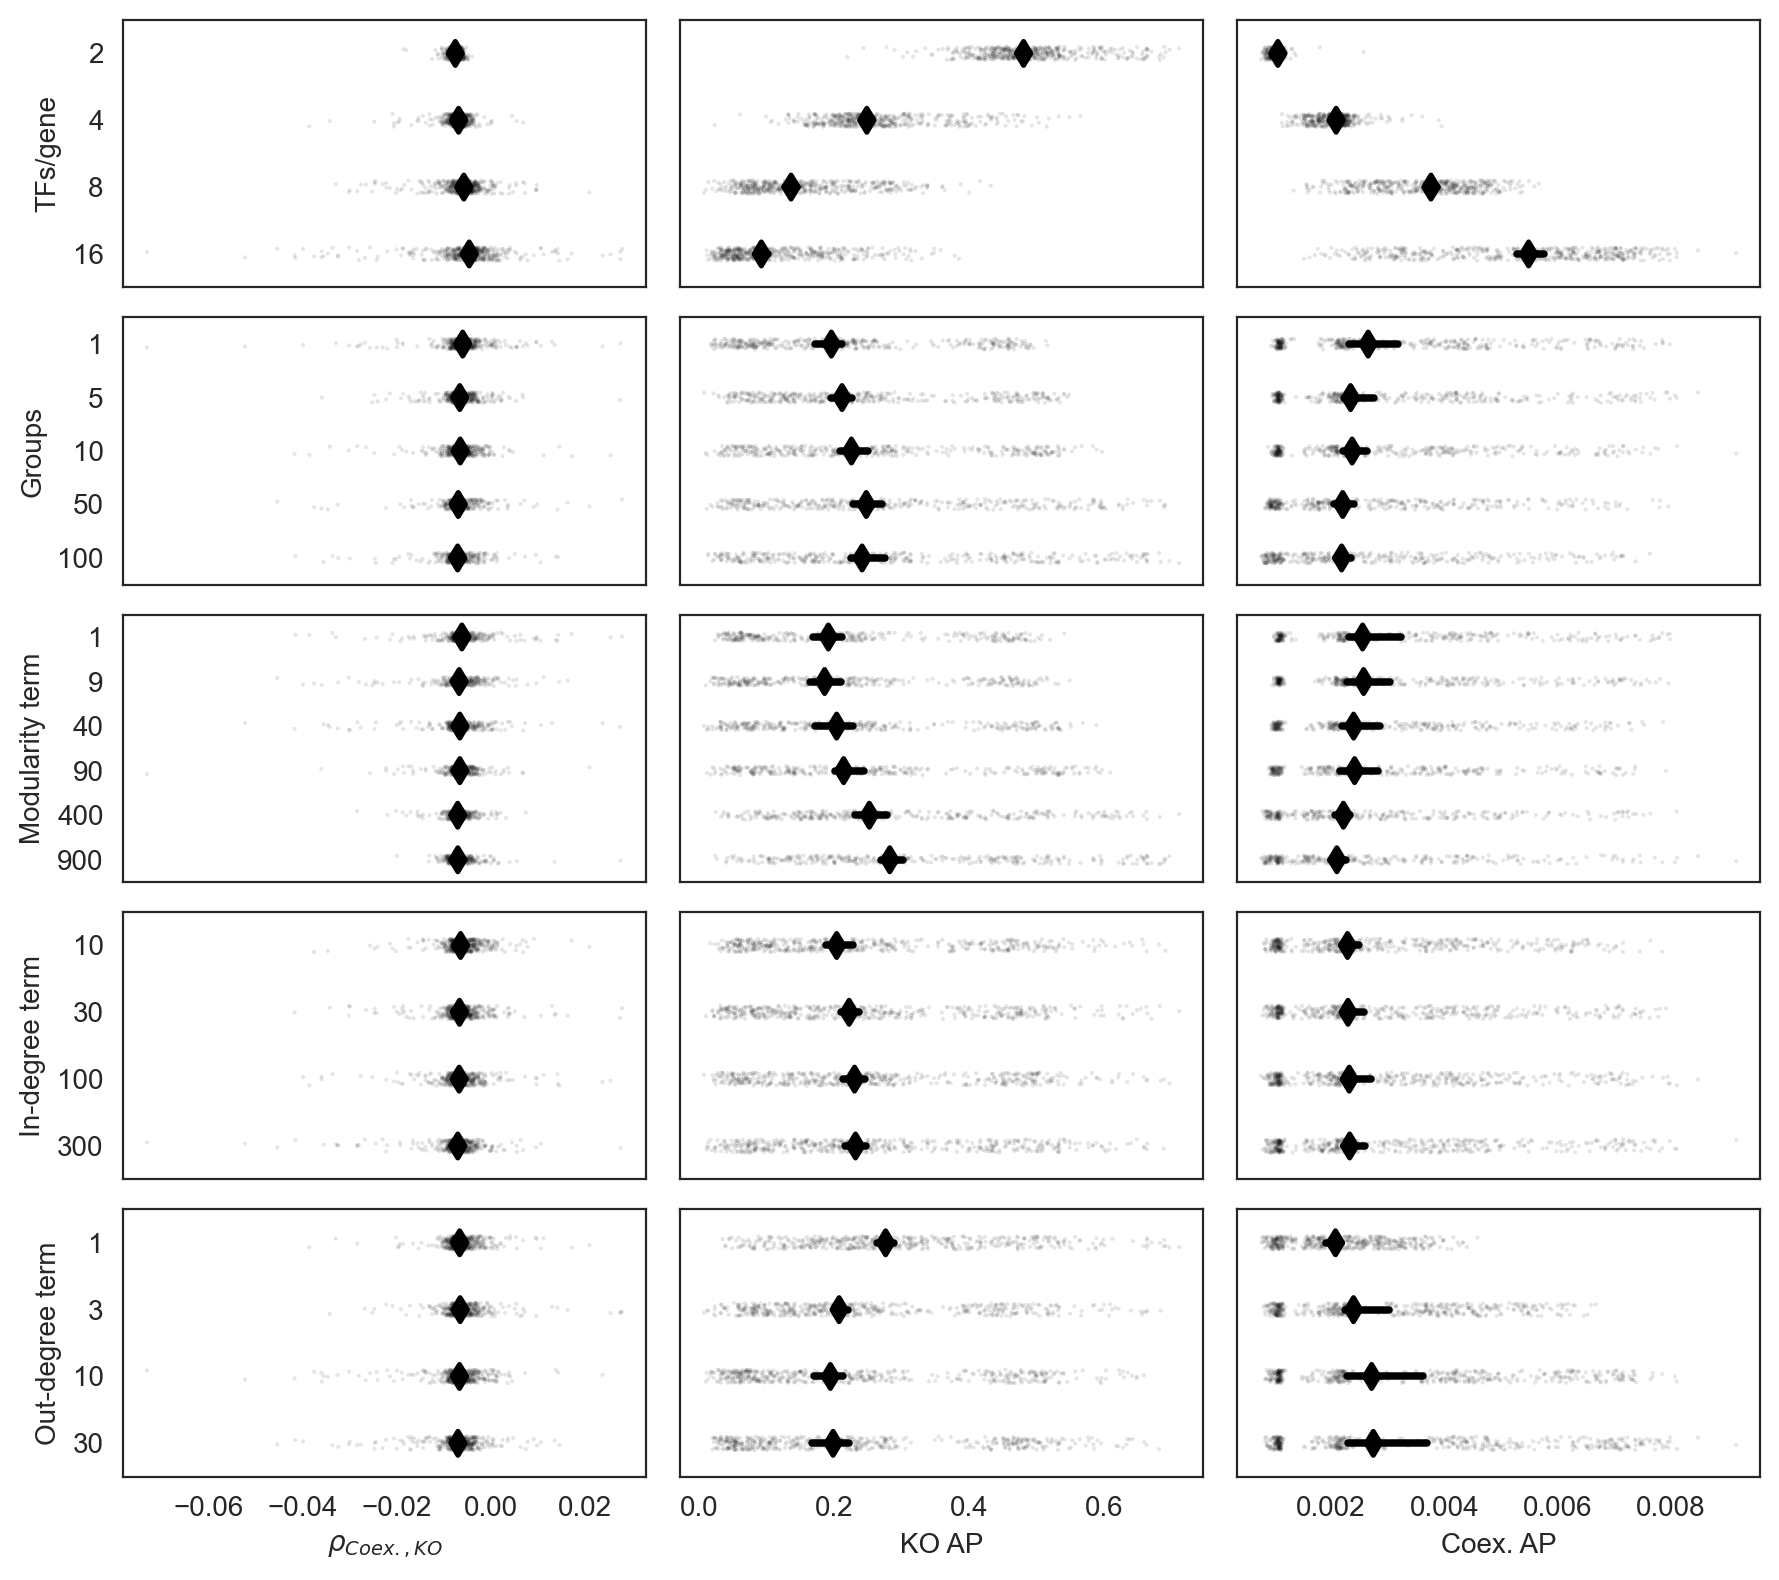

In [20]:
sns.set_style(None)

props=['r','k','w','delta_in','delta_out']
names=['TFs/gene', 'Groups', 'Modularity term', 'In-degree term', 'Out-degree term']

stats=['rho_r_ko', 'ap_ko', 'ap_r2']
shortlabs=[r'$\rho_{Coex., KO}$', 'KO AP', 'Coex. AP']
statdescs=['Rank correlation between coexpression and KO effect',
           'Average precision score of using abs. KO fold-changes to predict edges',
           'Average precision score of using abs. gene co-expression to predict edges'
           ]

fig, ax = plt.subplots(len(props), len(stats), figsize=(9,8), dpi=200)
if len(ax.shape) == 1:
    ax = ax.reshape(-1,1)
fig.set(facecolor='white')
d1, d2 = ax.shape

for i1,(prop,name) in enumerate(zip(props,names)):
    for i2,(stat, shortlab) in enumerate(zip(stats,shortlabs)):
        sns.stripplot(data = networks, 
                      x = stat, 
                      y = prop,
                      orient = 'h',
                      hue = None,
                      color = 'k',
                      dodge = True,
                      alpha = 0.1, 
                      size = 1.5,
                      zorder = 1, 
                      ax = ax[i1, i2]
        )
        sns.pointplot(data = networks, 
                      x = stat, 
                      y = prop,
                      orient = 'h',
                      estimator = np.median,
                      hue = None,
                      dodge = .8 - .8 / 3,
                      errorbar = None,
                      scale = 0.9,
                      linestyles = 'none',
                      color = 'k',
                      #palette = "dark",
                      markers = 'd', 
                      ax = ax[i1, i2]
        )
        if i1 == len(props)-1:
            ax[i1, i2].set_xlabel(shortlab);
        else:
            ax[i1, i2].set_xlabel('');
            ax[i1, i2].xaxis.set_tick_params(labelbottom=False)
        if i2 == 0:
            ax[i1, i2].set_ylabel(name)
        else:
            ax[i1, i2].set_ylabel('');
            ax[i1, i2].yaxis.set_tick_params(labelleft=False)
    
fig.tight_layout();

<AxesSubplot:xlabel='ap_ko', ylabel='ap_r2'>

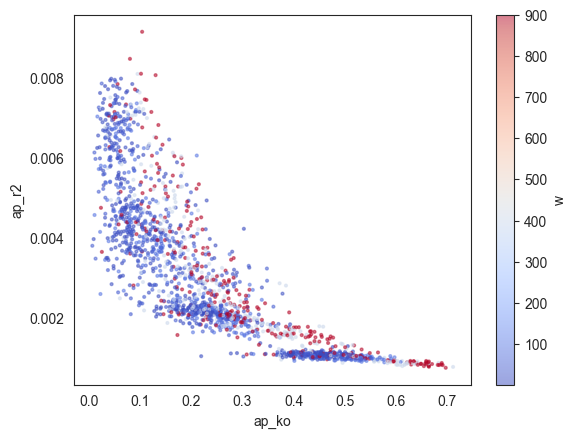

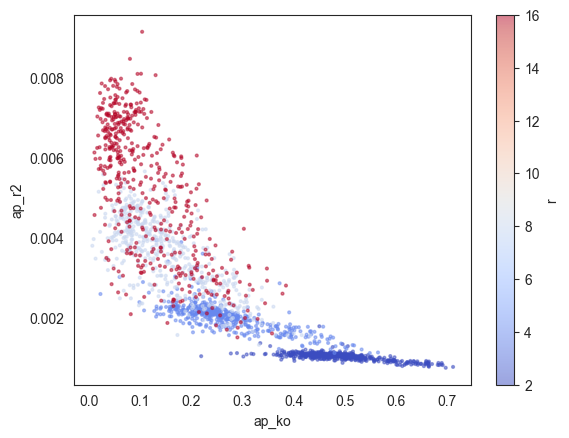

In [21]:
networks['wwk1'] = networks.w / (networks.w + networks.k - 1)
networks.plot.scatter(x='ap_ko', y='ap_r2', c='w', s=4, alpha=0.5, cmap='coolwarm');
networks.plot.scatter(x='ap_ko', y='ap_r2', c='r', s=4, alpha=0.5, cmap='coolwarm')